In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from pymongo import MongoClient
import time
import datetime
import os
from pyculiarity import detect_ts
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from dendrogram_class import Dendrogram, make_dendrogram, mask_mins
import pickle
import itertools
from collections import defaultdict, Counter
import scipy.stats as scs
from scipy import signal
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score, silhouette_samples
from pyramid.arima import auto_arima
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [132]:
with open('data/cs_df_M.pkl', 'rb') as f:
    df = pickle.load(f)

In [4]:
df['desc'] = df['item_name'] + ' ' + df['est_release_str']

In [5]:
anomaly_full = df[df.days_since_release > 30]

In [6]:
anomaly_full = mask_mins(anomaly_full, 0.1, 50)
anomaly_full = anomaly_full[anomaly_full.est_release < time.mktime(datetime.datetime.strptime('15 February 2018', "%d %B %Y").timetuple())] # not enough points
items = anomaly_full.item_name.unique()

In [41]:
anom_list = []
for item in items:
    temp_df = anomaly_full[anomaly_full.item_name == item]
    temp_df = temp_df[['timestamp', 'median_sell_price']].reset_index(drop=True)
    results = detect_ts(temp_df, max_anoms=0.3, alpha=0.001, direction='both', only_last=None, longterm=True, verbose=True, piecewise_median_period_weeks=3)
    if len(results['anoms'].index)>1 and results['anoms'].index[0] != temp_df['timestamp'][0]:
        anom_list += results['anoms'].index[1:]
    elif len(results['anoms'].index) > 0:
        anom_list += results['anoms'].index

In [44]:
anom_delta_dict = {}
for day in set(anom_list):
    start, end = day - datetime.timedelta(3), day + datetime.timedelta(3)
    anom_delta_dict[day]= sum(x >= start and x <= end for x in anom_list)
sorted_list = sorted(anom_delta_dict.items(), key=lambda x: x[1], reverse=True)
return_list = [sorted_list[0]]
for day in sorted_list[1:]:
    start, end = day[0] - datetime.timedelta(6), day[0] + datetime.timedelta(6)
    if any(x[0] >= start and x[0] <= end for x in return_list):
        continue
    else:
        return_list.append(day)
print(*[(x.date().strftime('%d %b %Y'), y) for x, y in sorted(return_list[:30])], sep='\n')

('22 Sep 2015', 313)
('17 Oct 2015', 208)
('04 Nov 2015', 207)
('29 Nov 2015', 602)
('09 Feb 2016', 254)
('15 Mar 2016', 486)
('21 May 2016', 296)
('10 Jul 2016', 235)
('04 Oct 2016', 202)
('30 Oct 2016', 570)
('27 Nov 2016', 718)
('02 Jan 2017', 333)
('23 Jan 2017', 294)
('16 Feb 2017', 230)
('18 Mar 2017', 188)
('25 Mar 2017', 263)
('27 May 2017', 678)
('24 Jun 2017', 503)
('03 Aug 2017', 249)
('23 Sep 2017', 284)
('23 Oct 2017', 213)
('30 Oct 2017', 338)
('26 Nov 2017', 873)
('21 Dec 2017', 273)
('09 Jan 2018', 199)
('28 Jan 2018', 217)
('21 Feb 2018', 289)
('02 Apr 2018', 253)
('11 Jun 2018', 209)
('26 Jun 2018', 790)


In [45]:
print(*[(x.date().strftime('%d %b %Y'), y) for x, y in return_list[:30]], sep='\n')

('26 Nov 2017', 873)
('26 Jun 2018', 790)
('27 Nov 2016', 718)
('27 May 2017', 678)
('29 Nov 2015', 602)
('30 Oct 2016', 570)
('24 Jun 2017', 503)
('15 Mar 2016', 486)
('30 Oct 2017', 338)
('02 Jan 2017', 333)
('22 Sep 2015', 313)
('21 May 2016', 296)
('23 Jan 2017', 294)
('21 Feb 2018', 289)
('23 Sep 2017', 284)
('21 Dec 2017', 273)
('25 Mar 2017', 263)
('09 Feb 2016', 254)
('02 Apr 2018', 253)
('03 Aug 2017', 249)
('10 Jul 2016', 235)
('16 Feb 2017', 230)
('28 Jan 2018', 217)
('23 Oct 2017', 213)
('11 Jun 2018', 209)
('17 Oct 2015', 208)
('04 Nov 2015', 207)
('04 Oct 2016', 202)
('09 Jan 2018', 199)
('18 Mar 2017', 188)


### What happens if I weight the anomalies by the quantity sold?

In [100]:
anomaly_full = df[df.days_since_release > 30]

In [101]:
anomaly_full = mask_mins(anomaly_full, 0.1, 25)
anomaly_full = anomaly_full[anomaly_full.est_release < time.mktime(datetime.datetime.strptime('15 February 2018', "%d %B %Y").timetuple())] # not enough points
items = anomaly_full.item_name.unique()

In [102]:
def anom_detect(df, item):
    fit_df = df[df.item_name == item]
    fit_df = fit_df[['timestamp', 'median_sell_price']].reset_index(drop=True)
    return detect_ts(fit_df, max_anoms=0.3, alpha=0.001, direction='both', only_last=None, longterm=True, verbose=True, piecewise_median_period_weeks=3)

In [103]:
anom_dict = defaultdict(lambda: 0)
for item in items:
    temp_df = anomaly_full[anomaly_full.item_name == item]
    results = anom_detect(temp_df, item)
    if len(results['anoms'].index)>0:
        for anomaly in results['anoms'].index:
            if anomaly != temp_df['date'].iloc[0]:
                anom_dict[anomaly] += temp_df[[datetime.datetime.fromtimestamp(t) == anomaly for t in temp_df.date]].quantity.values[0]
                #anom_dict[anomaly + datetime.timedelta(3)] += temp_df[temp_df.date == anomaly.timestamp()]
                #anom_dict[anomaly - datetime.timedelta(3)] += temp_df[temp_df.date == anomaly.timestamp()]

In [148]:
sorted(anom_dict.items(), key=lambda x: x[1], reverse=True)[:30]

[(Timestamp('2015-11-27 00:00:00'), 215822),
 (Timestamp('2015-11-28 00:00:00'), 196910),
 (Timestamp('2015-11-29 00:00:00'), 173462),
 (Timestamp('2015-11-26 00:00:00'), 158112),
 (Timestamp('2015-11-01 00:00:00'), 153567),
 (Timestamp('2017-05-24 00:00:00'), 152895),
 (Timestamp('2015-09-20 00:00:00'), 147283),
 (Timestamp('2015-05-27 00:00:00'), 145073),
 (Timestamp('2015-11-30 00:00:00'), 127708),
 (Timestamp('2015-09-22 00:00:00'), 125326),
 (Timestamp('2015-09-25 00:00:00'), 107371),
 (Timestamp('2015-09-21 00:00:00'), 106821),
 (Timestamp('2015-11-02 00:00:00'), 105753),
 (Timestamp('2015-05-01 00:00:00'), 98163),
 (Timestamp('2015-09-23 00:00:00'), 96418),
 (Timestamp('2015-09-19 00:00:00'), 95884),
 (Timestamp('2015-03-15 00:00:00'), 95731),
 (Timestamp('2015-09-24 00:00:00'), 83853),
 (Timestamp('2017-05-25 00:00:00'), 79441),
 (Timestamp('2015-03-16 00:00:00'), 79406),
 (Timestamp('2015-05-28 00:00:00'), 79039),
 (Timestamp('2015-09-26 00:00:00'), 76362),
 (Timestamp('2015-1

In [44]:
anom_delta_dict = {}
for day in set(anom_list):
    start, end = day - datetime.timedelta(3), day + datetime.timedelta(3)
    anom_delta_dict[day]= sum(x >= start and x <= end for x in anom_list)
sorted_list = sorted(anom_delta_dict.items(), key=lambda x: x[1], reverse=True)
return_list = [sorted_list[0]]
for day in sorted_list[1:]:
    start, end = day[0] - datetime.timedelta(6), day[0] + datetime.timedelta(6)
    if any(x[0] >= start and x[0] <= end for x in return_list):
        continue
    else:
        return_list.append(day)
print(*[(x.date().strftime('%d %b %Y'), y) for x, y in sorted(return_list[:30])], sep='\n')

('22 Sep 2015', 313)
('17 Oct 2015', 208)
('04 Nov 2015', 207)
('29 Nov 2015', 602)
('09 Feb 2016', 254)
('15 Mar 2016', 486)
('21 May 2016', 296)
('10 Jul 2016', 235)
('04 Oct 2016', 202)
('30 Oct 2016', 570)
('27 Nov 2016', 718)
('02 Jan 2017', 333)
('23 Jan 2017', 294)
('16 Feb 2017', 230)
('18 Mar 2017', 188)
('25 Mar 2017', 263)
('27 May 2017', 678)
('24 Jun 2017', 503)
('03 Aug 2017', 249)
('23 Sep 2017', 284)
('23 Oct 2017', 213)
('30 Oct 2017', 338)
('26 Nov 2017', 873)
('21 Dec 2017', 273)
('09 Jan 2018', 199)
('28 Jan 2018', 217)
('21 Feb 2018', 289)
('02 Apr 2018', 253)
('11 Jun 2018', 209)
('26 Jun 2018', 790)


In [45]:
print(*[(x.date().strftime('%d %b %Y'), y) for x, y in return_list[:30]], sep='\n')

('26 Nov 2017', 873)
('26 Jun 2018', 790)
('27 Nov 2016', 718)
('27 May 2017', 678)
('29 Nov 2015', 602)
('30 Oct 2016', 570)
('24 Jun 2017', 503)
('15 Mar 2016', 486)
('30 Oct 2017', 338)
('02 Jan 2017', 333)
('22 Sep 2015', 313)
('21 May 2016', 296)
('23 Jan 2017', 294)
('21 Feb 2018', 289)
('23 Sep 2017', 284)
('21 Dec 2017', 273)
('25 Mar 2017', 263)
('09 Feb 2016', 254)
('02 Apr 2018', 253)
('03 Aug 2017', 249)
('10 Jul 2016', 235)
('16 Feb 2017', 230)
('28 Jan 2018', 217)
('23 Oct 2017', 213)
('11 Jun 2018', 209)
('17 Oct 2015', 208)
('04 Nov 2015', 207)
('04 Oct 2016', 202)
('09 Jan 2018', 199)
('18 Mar 2017', 188)


#### Investigating November 2015

In [10]:
df[df.est_release < time.mktime(datetime.datetime.strptime('1 November 2015', "%d %B %Y").timetuple())].head()

,item_name,date_str,median_sell_price,quantity,est_release_str,days_since_release,gun_type,skin,quality,gun_bool,StatTrak,souvenir,keys,capsules,stickers,date,est_release,timestamp,desc
3802,Dual Berettas | Moon in Libra (Field-Tested),27 May 2015,0.285,1573,27 May 2015,0,Dual Berettas,Moon in Libra,Field-Tested,True,False,False,False,False,False,1.432703e+09,1.432703e+09,2015-05-27,Dual Berettas | Moon in Libra (Field-Tested) 2...
3803,Dual Berettas | Moon in Libra (Field-Tested),28 May 2015,0.278,1488,27 May 2015,1,Dual Berettas,Moon in Libra,Field-Tested,True,False,False,False,False,False,1.432789e+09,1.432703e+09,2015-05-28,Dual Berettas | Moon in Libra (Field-Tested) 2...
3804,Dual Berettas | Moon in Libra (Field-Tested),29 May 2015,0.373,877,27 May 2015,2,Dual Berettas,Moon in Libra,Field-Tested,True,False,False,False,False,False,1.432876e+09,1.432703e+09,2015-05-29,Dual Berettas | Moon in Libra (Field-Tested) 2...
3805,Dual Berettas | Moon in Libra (Field-Tested),30 May 2015,0.445,663,27 May 2015,3,Dual Berettas,Moon in Libra,Field-Tested,True,False,False,False,False,False,1.432962e+09,1.432703e+09,2015-05-30,Dual Berettas | Moon in Libra (Field-Tested) 2...
3806,Dual Berettas | Moon in Libra (Field-Tested),31 May 2015,0.526,479,27 May 2015,4,Dual Berettas,Moon in Libra,Field-Tested,True,False,False,False,False,False,1.433048e+09,1.432703e+09,2015-05-31,Dual Berettas | Moon in Libra (Field-Tested) 2...


In [11]:
x = df[df.item_name=='Dual Berettas | Moon in Libra (Field-Tested)']['timestamp']

In [12]:
y = df[df.item_name=='Dual Berettas | Moon in Libra (Field-Tested)'].median_sell_price

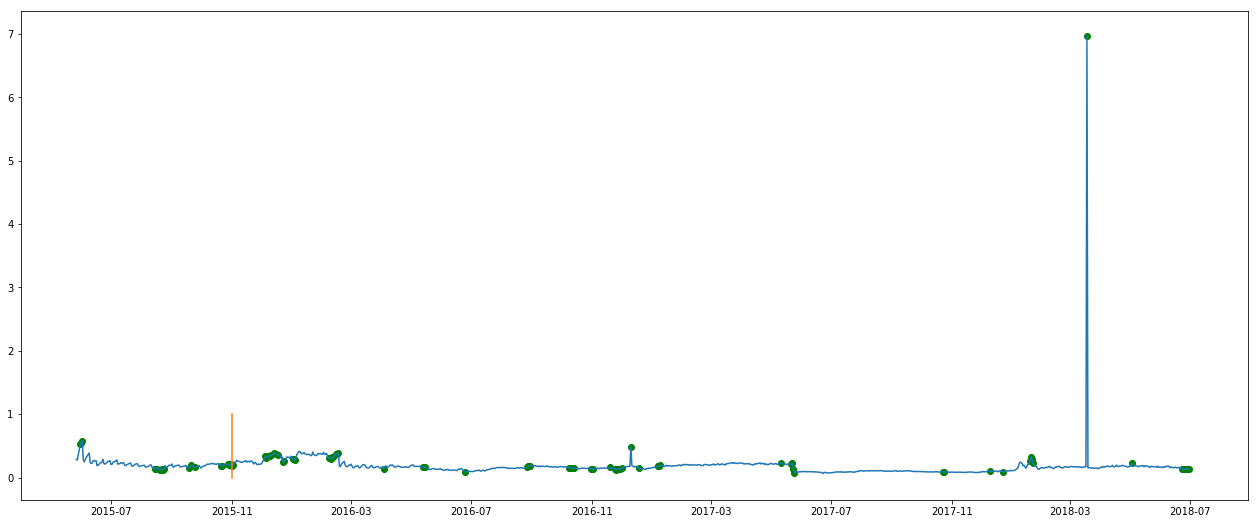

In [16]:
results = anom_detect(df[df['item_name'] == 'Dual Berettas | Moon in Libra (Field-Tested)'], 'Dual Berettas | Moon in Libra (Field-Tested)')
fig, ax = plt.subplots(figsize=(22, 9))
ax.plot(x, y)
ax.plot([np.datetime64(datetime.datetime.fromtimestamp(time.mktime(datetime.datetime.strptime('1 November 2015', "%d %B %Y").timetuple())).date())]*2, [0,1])
ax.scatter(results['anoms'].index, results['anoms']['anoms'], c='green')

### Auto arima outlier comparison

In [53]:
compare_df = df[df['item_name'] == 'Dual Berettas | Moon in Libra (Field-Tested)']
compare_df.loc[4828, 'median_sell_price'] = np.median(compare_df.median_sell_price)

In [54]:

model = auto_arima(compare_df.median_sell_price)
resid_df = pd.DataFrame({'timestamp': compare_df.timestamp, 'resid': model.resid(), 'raw': compare_df.median_sell_price, 'pred': model.predict_in_sample()})

mean = np.mean(resid_df.raw[1:])
std = np.std(resid_df.raw[1:])
outliers = resid_df[(resid_df.raw > mean + 3*std) | (resid_df.raw < mean - 3*std)]

In [77]:
base = datetime.datetime(2018, 7, 1)
arr = np.arange(datetime.datetime(2018,7,1), datetime.datetime(2019,1,1), datetime.timedelta(days=1)).astype(datetime.datetime)

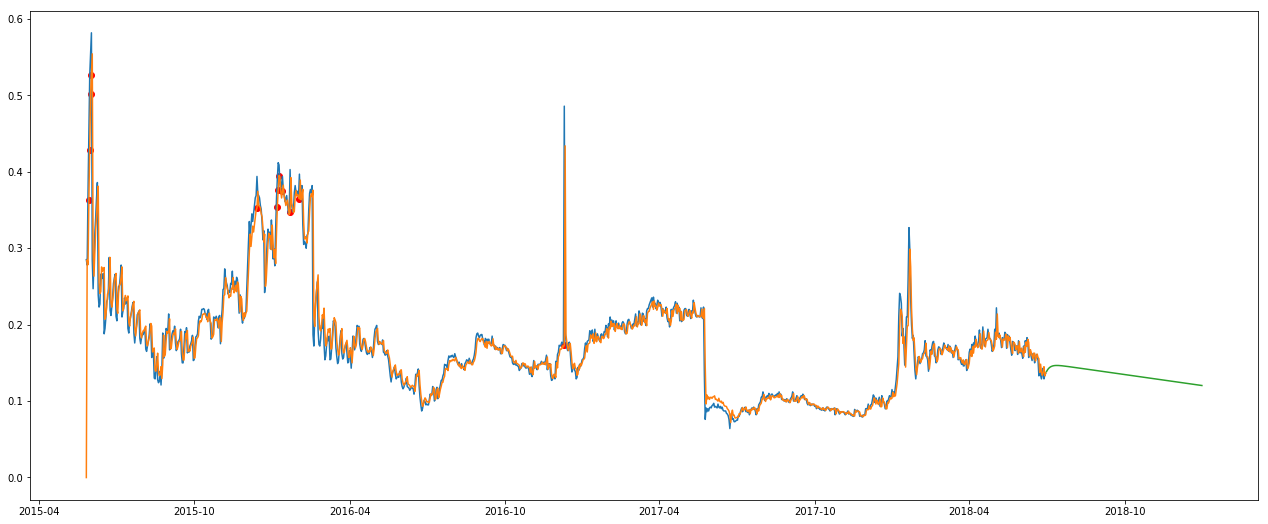

In [78]:
fig, ax = plt.subplots(figsize=(22,9))
ax.plot(compare_df.timestamp, compare_df.median_sell_price)
ax.plot(compare_df.timestamp, compare_df.median_sell_price - model.resid())
ax.plot(arr, model.predict(n_periods=len(arr)))
ax.scatter(outliers.timestamp.values, outliers.pred.values, c='red')

In [56]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1131
Model:               SARIMAX(1, 1, 1)   Log Likelihood                2734.417
Date:                Sat, 18 Aug 2018   AIC                          -5460.833
Time:                        12:27:54   BIC                          -5440.713
Sample:                             0   HQIC                         -5453.232
                               - 1131                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.167e-05    4.2e-05     -0.754      0.451      -0.000    5.07e-05
ar.L1          0.7992      0.013     60.577      0.000       0.773       0.825
ma.L1         -0.9535      0.011    -88.893      0.000      -0.975      -0.932
sigma2         0.0005   3.73e-06    124.205      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                      186.60   Jarque-Bera (JB):            314712.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                            -1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        84.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

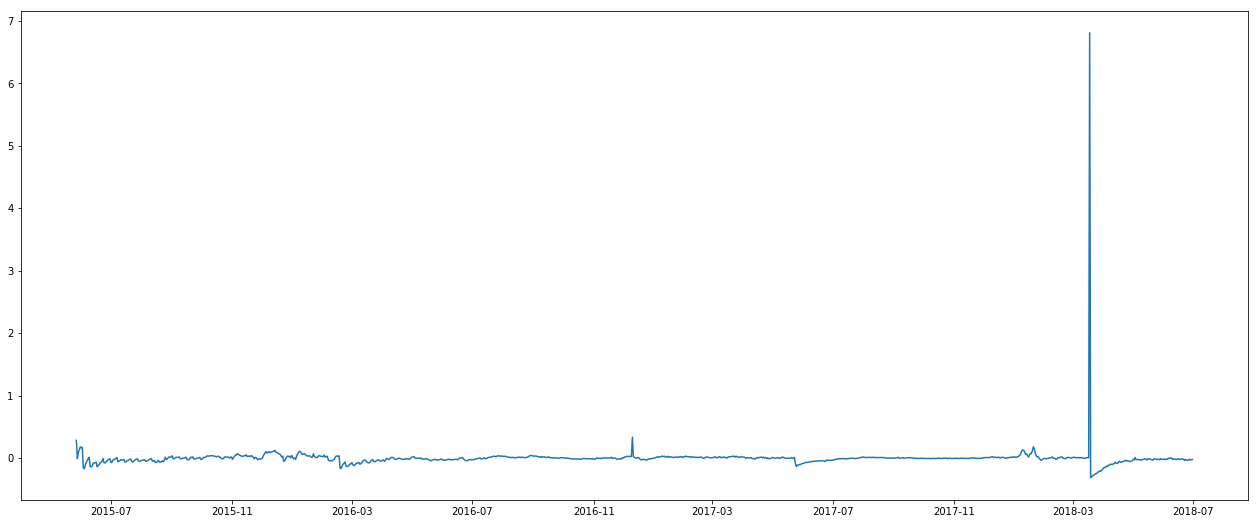

In [39]:
fig, ax = plt.subplots(figsize=(22,9))
ax.plot(compare_df.timestamp, model.resid())

### Number of items available on a given day

In [80]:
df.head()

,item_name,date_str,median_sell_price,quantity,est_release_str,days_since_release,gun_type,skin,quality,gun_bool,StatTrak,souvenir,keys,capsules,stickers,date,est_release,timestamp
0,Glock-18 | Weasel (Battle-Scarred),19 Aug 2016,6.193,135,19 Aug 2016,0,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.471583e+09,1.471583e+09,2016-08-19
1,Glock-18 | Weasel (Battle-Scarred),20 Aug 2016,5.103,166,19 Aug 2016,1,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.471669e+09,1.471583e+09,2016-08-20
2,Glock-18 | Weasel (Battle-Scarred),21 Aug 2016,4.721,142,19 Aug 2016,2,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.471756e+09,1.471583e+09,2016-08-21
3,Glock-18 | Weasel (Battle-Scarred),22 Aug 2016,4.302,98,19 Aug 2016,3,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.471842e+09,1.471583e+09,2016-08-22
4,Glock-18 | Weasel (Battle-Scarred),23 Aug 2016,3.898,125,19 Aug 2016,4,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.471928e+09,1.471583e+09,2016-08-23


In [82]:
df_num_items = df.groupby('item_name').agg('median')

In [83]:
df_num_items.head()

,median_sell_price,quantity,days_since_release,gun_bool,StatTrak,souvenir,keys,capsules,stickers,date,est_release
item_name,,,,,,,,,,,
AK-47 | Aquamarine Revenge (Battle-Scarred),11.536,106.0,565.0,True,False,False,False,False,False,1.481522e+09,1.432703e+09
AK-47 | Aquamarine Revenge (Factory New),36.005,36.0,565.0,True,False,False,False,False,False,1.481522e+09,1.432703e+09
AK-47 | Aquamarine Revenge (Field-Tested),17.574,249.0,565.0,True,False,False,False,False,False,1.481522e+09,1.432703e+09
AK-47 | Aquamarine Revenge (Minimal Wear),24.727,120.0,565.0,True,False,False,False,False,False,1.481522e+09,1.432703e+09
AK-47 | Aquamarine Revenge (Well-Worn),14.590,133.0,565.0,True,False,False,False,False,False,1.481522e+09,1.432703e+09


In [84]:
index = [pd.to_datetime(t, unit='s') for t in df_num_items.est_release]

In [86]:
df_num_items['release_timestamp'] = index

In [88]:
df_num_items['release_timestamp'] = [t.date() for t in df_num_items['release_timestamp']]

In [89]:
df_num_items.head()

,median_sell_price,quantity,days_since_release,gun_bool,StatTrak,souvenir,keys,capsules,stickers,date,est_release,release_timestamp
item_name,,,,,,,,,,,,
AK-47 | Aquamarine Revenge (Battle-Scarred),11.536,106.0,565.0,True,False,False,False,False,False,1.481522e+09,1.432703e+09,2015-05-27
AK-47 | Aquamarine Revenge (Factory New),36.005,36.0,565.0,True,False,False,False,False,False,1.481522e+09,1.432703e+09,2015-05-27
AK-47 | Aquamarine Revenge (Field-Tested),17.574,249.0,565.0,True,False,False,False,False,False,1.481522e+09,1.432703e+09,2015-05-27
AK-47 | Aquamarine Revenge (Minimal Wear),24.727,120.0,565.0,True,False,False,False,False,False,1.481522e+09,1.432703e+09,2015-05-27
AK-47 | Aquamarine Revenge (Well-Worn),14.590,133.0,565.0,True,False,False,False,False,False,1.481522e+09,1.432703e+09,2015-05-27


In [93]:
df_num_items = df_num_items.groupby('release_timestamp').count()

In [94]:
df_num_items['total_released'] = np.cumsum(df_num_items.median_sell_price)

In [95]:
df_num_items.head()

,median_sell_price,quantity,days_since_release,gun_bool,StatTrak,souvenir,keys,capsules,stickers,date,est_release,total_released
release_timestamp,,,,,,,,,,,,
2013-04-26,1,1,1,1,1,1,1,1,1,1,1,1
2013-08-13,5,5,5,5,5,5,5,5,5,5,5,6
2013-08-14,47,47,47,47,47,47,47,47,47,47,47,53
2013-08-15,249,249,249,249,249,249,249,249,249,249,249,302
2013-08-16,55,55,55,55,55,55,55,55,55,55,55,357


In [96]:
num_items = df_num_items.total_released

In [114]:
num_items = num_items.reset_index()

In [116]:
num_items['timestamp'] = [pd.to_datetime(t) for t in num_items['release_timestamp']]

In [117]:
num_items.head()

,release_timestamp,total_released,timestamp
0,2013-04-26,1,2013-04-26
1,2013-08-13,6,2013-08-13
2,2013-08-14,53,2013-08-14
3,2013-08-15,302,2013-08-15
4,2013-08-16,357,2013-08-16


In [110]:
pd.to_datetime(num_items.index[0])

Timestamp('2013-04-26 00:00:00')

In [112]:
list(anom_dict.keys())[0] > pd.to_datetime(num_items.index[0])

True

In [118]:
scaled_anom_dict = {}
for key, val in anom_dict.items():
    scaled_anom_dict[key] = val / np.max(num_items[num_items.timestamp <= key]['total_released'])

In [120]:
sorted_list = sorted(scaled_anom_dict.items(), key=lambda x: x[1], reverse=True)
print(*[(x.date().strftime('%d %b %Y'), y) for x, y in sorted_list[:30]], sep='\n')

('27 Nov 2015', 47.32305837781987)
('28 Nov 2015', 43.78129843292578)
('27 May 2015', 42.50391644908616)
('29 Nov 2015', 38.31548131565352)
('26 Nov 2015', 34.44980196314793)
('15 Mar 2015', 34.089379122128726)
('01 Nov 2015', 32.162962962962965)
('20 Sep 2015', 31.037057220708448)
('30 Nov 2015', 29.085241949371447)
('16 Mar 2015', 27.505571980896065)
('01 May 2015', 26.10056843025798)
('22 Sep 2015', 25.921348314606742)
('17 Dec 2014', 25.257752418754652)
('21 Sep 2015', 23.430618538001088)
('02 Nov 2015', 22.768130921619292)
('25 Sep 2015', 21.755168074779796)
('28 May 2015', 21.69513902780556)
('19 Sep 2015', 20.926997997451302)
('24 May 2017', 20.681827888105914)
('23 Sep 2015', 20.340579710144926)
('17 Apr 2015', 19.073772296850915)
('01 Dec 2015', 18.541759944894093)
('24 Sep 2015', 18.006700470843896)
('17 Oct 2015', 17.575779290576854)
('26 Sep 2015', 16.409556313993175)
('06 Feb 2014', 15.954191479615208)
('18 Feb 2016', 15.897814910025707)
('16 Apr 2015', 15.513108614232209)

In [121]:
df.head()

,item_name,date_str,median_sell_price,quantity,est_release_str,days_since_release,gun_type,skin,quality,gun_bool,StatTrak,souvenir,keys,capsules,stickers,date,est_release,timestamp
0,Glock-18 | Weasel (Battle-Scarred),19 Aug 2016,6.193,135,19 Aug 2016,0,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.471583e+09,1.471583e+09,2016-08-19
1,Glock-18 | Weasel (Battle-Scarred),20 Aug 2016,5.103,166,19 Aug 2016,1,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.471669e+09,1.471583e+09,2016-08-20
2,Glock-18 | Weasel (Battle-Scarred),21 Aug 2016,4.721,142,19 Aug 2016,2,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.471756e+09,1.471583e+09,2016-08-21
3,Glock-18 | Weasel (Battle-Scarred),22 Aug 2016,4.302,98,19 Aug 2016,3,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.471842e+09,1.471583e+09,2016-08-22
4,Glock-18 | Weasel (Battle-Scarred),23 Aug 2016,3.898,125,19 Aug 2016,4,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.471928e+09,1.471583e+09,2016-08-23


In [123]:
df_test = df[df.item_name == 'Dual Berettas | Moon in Libra (Field-Tested)']

In [126]:
df_test.iloc[0]['date_str']

'27 May 2015'

In [129]:
from date_util import epoch_to_np
df['timestamp2'] = [epoch_to_np(t) for t in df['date']]

In [133]:
df.head()

,item_name,date_str,median_sell_price,quantity,est_release_str,days_since_release,gun_type,skin,quality,gun_bool,StatTrak,souvenir,keys,capsules,stickers,date,est_release,timestamp
0,Glock-18 | Weasel (Battle-Scarred),19 Aug 2016,6.193,135,19 Aug 2016,0,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.471583e+09,1.471583e+09,2016-08-19
1,Glock-18 | Weasel (Battle-Scarred),20 Aug 2016,5.103,166,19 Aug 2016,1,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.471669e+09,1.471583e+09,2016-08-20
2,Glock-18 | Weasel (Battle-Scarred),21 Aug 2016,4.721,142,19 Aug 2016,2,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.471756e+09,1.471583e+09,2016-08-21
3,Glock-18 | Weasel (Battle-Scarred),22 Aug 2016,4.302,98,19 Aug 2016,3,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.471842e+09,1.471583e+09,2016-08-22
4,Glock-18 | Weasel (Battle-Scarred),23 Aug 2016,3.898,125,19 Aug 2016,4,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.471928e+09,1.471583e+09,2016-08-23


In [134]:
import twitter_on_arima

In [154]:
df = twitter_on_arima.import_data()

In [155]:
anom_dict = defaultdict(lambda: 0)


dataframe, release_date = twitter_on_arima.prep_data(df, 'Dual Berettas | Moon in Libra (Field-Tested)')
results = twitter_on_arima.arima_smooth(dataframe)
results = twitter_on_arima.detect_anoms(results)
anom_dict = twitter_on_arima.update_anoms(anom_dict, results, release_date)
s = twitter_on_arima.sort_dict(anom_dict)

TypeError: strptime() argument 1 must be str, not int

In [156]:
results

,timestamp,pred_price
0,1,0.284868
1,2,0.281298
2,3,0.311838
3,4,0.345236
4,5,0.381701
5,6,0.410654
6,7,0.435649
7,8,0.415885
8,9,0.396124
9,10,0.384132


In [141]:
df.head()

,item_name,date_str,median_sell_price,quantity,est_release_str,days_since_release,gun_type,skin,quality,gun_bool,StatTrak,souvenir,keys,capsules,stickers,date,est_release,timestamp,min_quant,min_price
31,Glock-18 | Weasel (Battle-Scarred),19 Sep 2016,1.970,139,19 Aug 2016,31,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.474261e+09,1.471583e+09,2016-09-19,57,0.335
32,Glock-18 | Weasel (Battle-Scarred),20 Sep 2016,1.927,128,19 Aug 2016,32,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.474348e+09,1.471583e+09,2016-09-20,57,0.335
33,Glock-18 | Weasel (Battle-Scarred),21 Sep 2016,1.909,119,19 Aug 2016,33,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.474434e+09,1.471583e+09,2016-09-21,57,0.335
34,Glock-18 | Weasel (Battle-Scarred),22 Sep 2016,1.856,142,19 Aug 2016,34,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.474520e+09,1.471583e+09,2016-09-22,57,0.335
35,Glock-18 | Weasel (Battle-Scarred),23 Sep 2016,1.830,156,19 Aug 2016,35,Glock-18,Weasel,Battle-Scarred,True,False,False,False,False,False,1.474607e+09,1.471583e+09,2016-09-23,57,0.335


In [160]:
from tqdm import tqdm

In [162]:
for x in tqdm(range(10)):
    print(x)

100%|██████████| 10/10 [00:00<00:00, 2369.13it/s]

0
1
2
3
4
5
6
7
8
9


In [ ]:
auto_arima()